In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
df = pd.read_csv('/content/MC-data.csv')
df.shape


(602, 2)

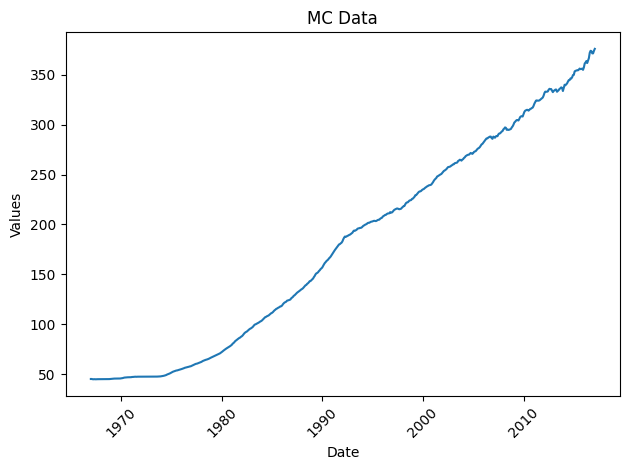

In [ ]:
#MC - dataset
import pandas as pd
import matplotlib.pyplot as plt



df = pd.read_csv('/content/MC-data.csv')  # Replace 'your_data.csv' with your file path

# Convert 'date' column to datetime objects
df['observation_date'] = pd.to_datetime(df['observation_date'])

# Set the 'date' column as the index of the DataFrame
df.set_index('observation_date', inplace=True)

# Plot the 'values' column against the index (dates)
plt.plot(df.index, df['CUUR0000SAM1'])

# Add title and labels
plt.title('MC Data')
plt.xlabel('Date')
plt.ylabel('Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust plot layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
adf_result = adfuller(df['CUUR0000SAM1'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: 1.6347497220939182
p-value: 0.9979581725795238


In [ ]:
df['diff'] = df['CUUR0000SAM1'].diff().dropna()

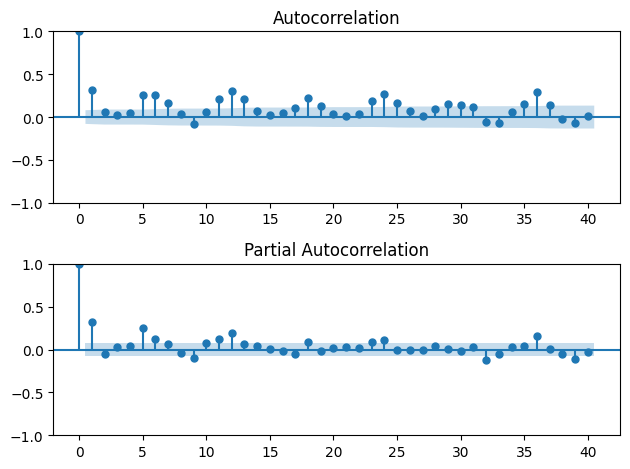

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plt.title('MC Data')
plot_acf(df['diff'].dropna(), ax=ax1, lags=40)
plot_pacf(df['diff'].dropna(), ax=ax2, lags=40)
plt.tight_layout()
plt.show()

ADF Statistic (Differenced): -3.025751323788014
p-value (Differenced): 0.03255853348619746
ARIMA RMSE: 6.163644854452635


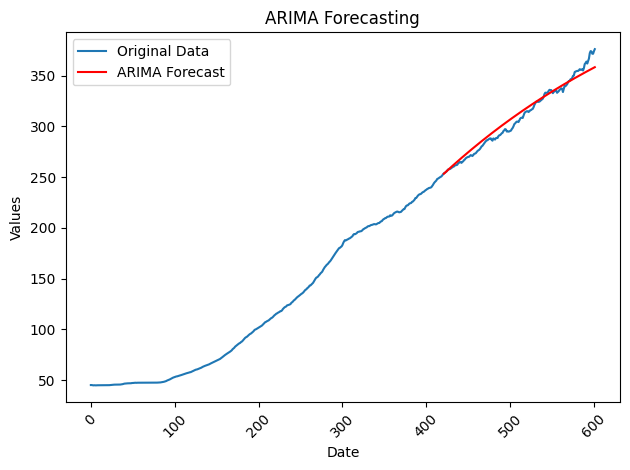

In [ ]:
# ARIMA Forecasting
# Since p-value is > 0.05, data is not stationary. We must difference.
# We will check the differenced data's ADF test.
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

differenced_data = df['CUUR0000SAM1'].diff().dropna()
adf_diff_result = adfuller(differenced_data)
print(f'ADF Statistic (Differenced): {adf_diff_result[0]}')
print(f'p-value (Differenced): {adf_diff_result[1]}')

# If the differenced data is stationary (p<0.05), we can use d=1.

# Split data into train and test sets
train_size = int(len(df) * 0.7)
train, test = df['CUUR0000SAM1'][:train_size], df['CUUR0000SAM1'][train_size:]

# Fit ARIMA model.
# The parameters (p, d, q) should be chosen based on ACF and PACF plots, or auto arima.
# Here, we use the graphs
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {rmse}')

# Plot the results

plt.plot(df.index, df['CUUR0000SAM1'], label='Original Data')
plt.plot(test.index, forecast, color='red', label='ARIMA Forecast')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7k4bzi8h/1y38o83r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7k4bzi8h/msbgvehe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61930', 'data', 'file=/tmp/tmp7k4bzi8h/1y38o83r.json', 'init=/tmp/tmp7k4bzi8h/msbgvehe.json', 'output', 'file=/tmp/tmp7k4bzi8h/prophet_modeld9hacyta/prophet_model-20250408054105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:41:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 8.355379956818453


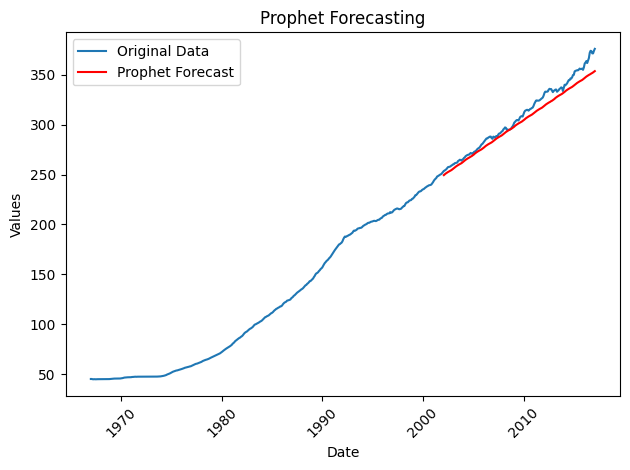

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the dataset
df = pd.read_csv('/content/MC-data.csv')

# Prepare data for Prophet
prophet_df = df[['observation_date', 'CUUR0000SAM1']].copy()
prophet_df.rename(columns={'observation_date': 'ds', 'CUUR0000SAM1': 'y'}, inplace=True)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Split data into train and test sets
train_size = int(len(prophet_df) * 0.7)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

# Fit Prophet model
model = Prophet()
model.fit(train_df)

# Make future dataframe for forecasting
future = model.make_future_dataframe(periods=len(test_df), freq='MS') # Monthly start frequency

# Forecast
forecast = model.predict(future)

# Extract predictions for the test period
prophet_predictions = forecast['yhat'][-len(test_df):].values
actuals = test_df['y'].values

# Calculate RMSE
rmse = sqrt(mean_squared_error(actuals, prophet_predictions))
print(f'Prophet RMSE: {rmse}')

# Plot the forecast
plt.plot(prophet_df['ds'], prophet_df['y'], label='Original Data')
plt.plot(test_df['ds'], prophet_predictions, color='red', label='Prophet Forecast')
plt.title('Prophet Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
NARNN RMSE: 8.210364404311346


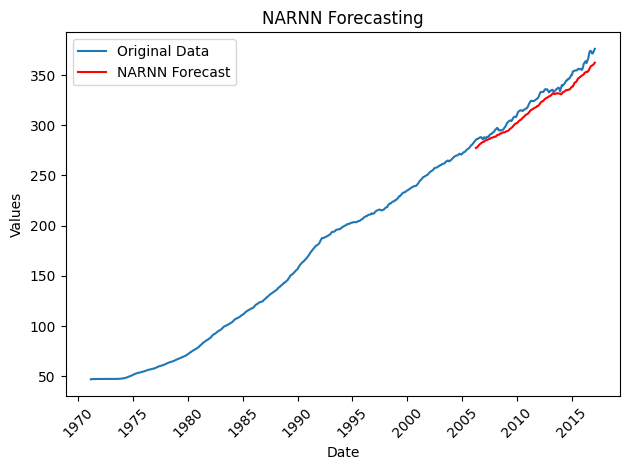

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load dataset
df = pd.read_csv('/content/MC-data.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)

# Extract values
data = df['CUUR0000SAM1'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset for NARNN
def create_narnn_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Parameters
look_back = 50
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size

# Create the dataset
X, y = create_narnn_dataset(scaled_data, look_back)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for NARNN (no time steps dimension needed like LSTM)
n_features = 1
X_train = X_train.reshape((X_train.shape[0], look_back * n_features))
X_test = X_test.reshape((X_test.shape[0], look_back * n_features))

# Build NARNN model
narnn_model = Sequential()
narnn_model.add(Dense(50, activation='relu', input_shape=(look_back * n_features,)))
narnn_model.add(Dense(50, activation='relu'))
narnn_model.add(Dense(1))
narnn_model.compile(optimizer='adam', loss='mse')

# Train the NARNN model
narnn_model.fit(X_train, y_train, epochs=100, verbose=0, batch_size=32)

# Make predictions
scaled_predictions = narnn_model.predict(X_test)

# Inverse transform predictions
predictions = scaler.inverse_transform(scaled_predictions)
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print(f'NARNN RMSE: {rmse}')

# Plot results

plt.plot(df.index[look_back:], scaler.inverse_transform(scaled_data[look_back:]), label='Original Data')
plt.plot(df.index[train_size + look_back:], predictions, color='red', label='NARNN Forecast')
plt.title('NARNN Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

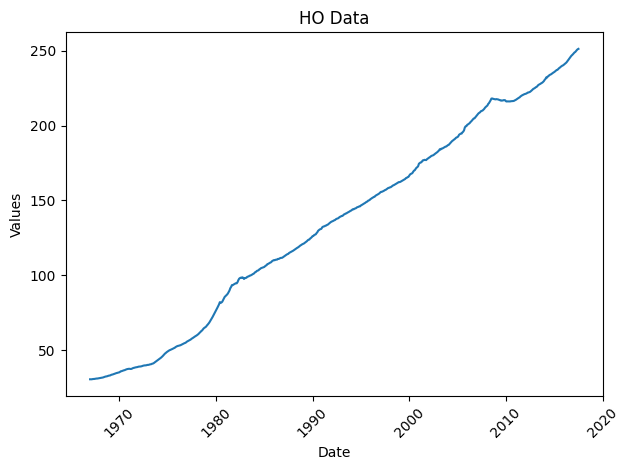

In [ ]:
#HO - dataset
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a CSV file named 'your_data.csv'
# and has columns 'date' and 'values'

df = pd.read_csv('/content/HO-data.csv')
df.shape

# Convert 'date' column to datetime objects
df['observation_date'] = pd.to_datetime(df['observation_date'])

# Set the 'date' column as the index of the DataFrame
df.set_index('observation_date', inplace=True)

# Plot the 'values' column against the index (dates)
plt.plot(df.index, df['CPIHOSSL'])

# Add title and labels
plt.title('HO Data')
plt.xlabel('Date')
plt.ylabel('Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust plot layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df.shape

(607, 1)

In [ ]:
adf_result = adfuller(df['CPIHOSSL'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: 0.23874401370809453
p-value: 0.9743528024663057


In [ ]:
df['diff'] = df['CPIHOSSL'].diff().dropna()

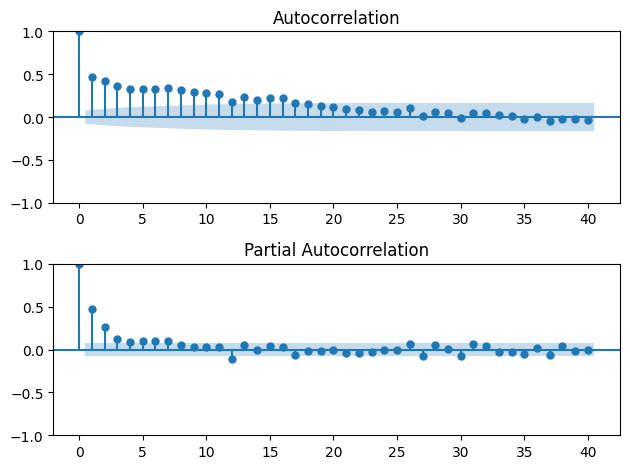

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_acf(df['diff'].dropna(), ax=ax1, lags=40)
plot_pacf(df['diff'].dropna(), ax=ax2, lags=40)
plt.tight_layout()
plt.show()

ADF Statistic (Differenced): -3.8827544907468137
p-value (Differenced): 0.002165494764425844


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA RMSE: 13.310153151497106


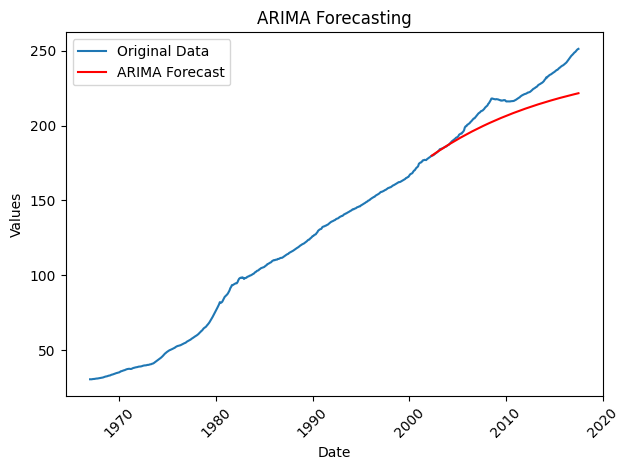

In [ ]:
# ARIMA Forecasting
# Since p-value is > 0.05, data is not stationary. We must difference.
# We will check the differenced data's ADF test.
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

differenced_data = df['CPIHOSSL'].diff().dropna()
adf_diff_result = adfuller(differenced_data)
print(f'ADF Statistic (Differenced): {adf_diff_result[0]}')
print(f'p-value (Differenced): {adf_diff_result[1]}')

# If the differenced data is stationary (p<0.05), we can use d=1.

# Split data into train and test sets
train_size = int(len(df) * 0.7)
train, test = df['CPIHOSSL'][:train_size], df['CPIHOSSL'][train_size:]

# Fit ARIMA model.
# The parameters (p, d, q) should be chosen based on ACF and PACF plots, or auto arima.
# Here, we use the graphs
model = ARIMA(train, order=(1, 1, 4))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {rmse}')

# Plot the results

plt.plot(df.index, df['CPIHOSSL'], label='Original Data')
plt.plot(test.index, forecast, color='red', label='ARIMA Forecast')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7k4bzi8h/n4qwjv_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7k4bzi8h/hie61gki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32573', 'data', 'file=/tmp/tmp7k4bzi8h/n4qwjv_a.json', 'init=/tmp/tmp7k4bzi8h/hie61gki.json', 'output', 'file=/tmp/tmp7k4bzi8h/prophet_model638sabqm/prophet_model-20250408054324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:43:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:43:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 4.496194210263853


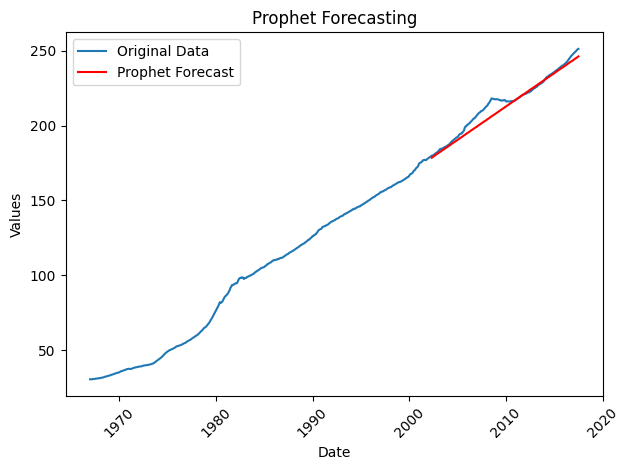

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the dataset
df = pd.read_csv('/content/HO-data.csv')

# Prepare data for Prophet
prophet_df = df[['observation_date', 'CPIHOSSL']].copy()
prophet_df.rename(columns={'observation_date': 'ds', 'CPIHOSSL': 'y'}, inplace=True)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Split data into train and test sets
train_size = int(len(prophet_df) * 0.7)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

# Fit Prophet model
model = Prophet()
model.fit(train_df)

# Make future dataframe for forecasting
future = model.make_future_dataframe(periods=len(test_df), freq='MS') # Monthly start frequency

# Forecast
forecast = model.predict(future)

# Extract predictions for the test period
prophet_predictions = forecast['yhat'][-len(test_df):].values
actuals = test_df['y'].values

# Calculate RMSE
rmse = sqrt(mean_squared_error(actuals, prophet_predictions))
print(f'Prophet RMSE: {rmse}')

# Plot the forecast
plt.plot(prophet_df['ds'], prophet_df['y'], label='Original Data')
plt.plot(test_df['ds'], prophet_predictions, color='red', label='Prophet Forecast')
plt.title('Prophet Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
NARNN RMSE: 3.1208723271905137


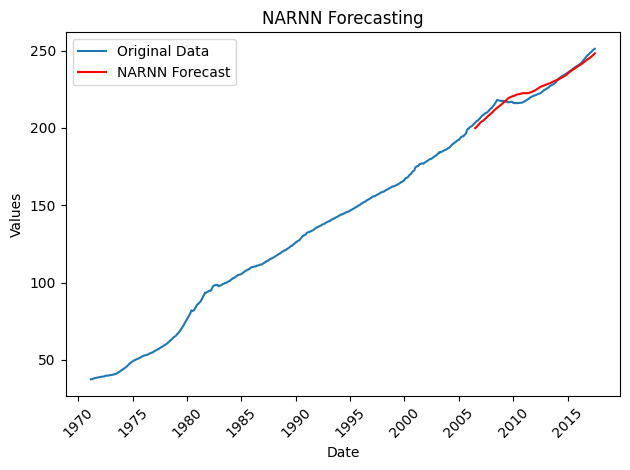

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load dataset
df = pd.read_csv('/content/HO-data.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)

# Extract values
data = df['CPIHOSSL'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset for NARNN
def create_narnn_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Parameters
look_back = 50
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size

# Create the dataset
X, y = create_narnn_dataset(scaled_data, look_back)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for NARNN (no time steps dimension needed like LSTM)
n_features = 1
X_train = X_train.reshape((X_train.shape[0], look_back * n_features))
X_test = X_test.reshape((X_test.shape[0], look_back * n_features))

# Build NARNN model
narnn_model = Sequential()
narnn_model.add(Dense(50, activation='relu', input_shape=(look_back * n_features,)))
narnn_model.add(Dense(50, activation='relu'))
narnn_model.add(Dense(1))
narnn_model.compile(optimizer='adam', loss='mse')

# Train the NARNN model
narnn_model.fit(X_train, y_train, epochs=100, verbose=0, batch_size=32)

# Make predictions
scaled_predictions = narnn_model.predict(X_test)

# Inverse transform predictions
predictions = scaler.inverse_transform(scaled_predictions)
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print(f'NARNN RMSE: {rmse}')

# Plot results

plt.plot(df.index[look_back:], scaler.inverse_transform(scaled_data[look_back:]), label='Original Data')
plt.plot(df.index[train_size + look_back:], predictions, color='red', label='NARNN Forecast')
plt.title('NARNN Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

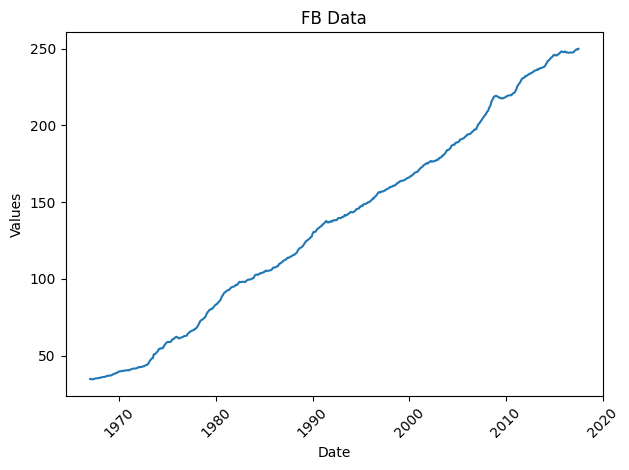

In [ ]:
#FB - dataset
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a CSV file named 'your_data.csv'
# and has columns 'date' and 'values'

df = pd.read_csv('/content/FB - data.csv')  # Replace 'your_data.csv' with your file path

# Convert 'date' column to datetime objects
df['observation_date'] = pd.to_datetime(df['observation_date'])

# Set the 'date' column as the index of the DataFrame
df.set_index('observation_date', inplace=True)

# Plot the 'values' column against the index (dates)
plt.plot(df.index, df['CPIFABSL'])

# Add title and labels
plt.title('FB Data')
plt.xlabel('Date')
plt.ylabel('Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust plot layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df.shape

(607, 1)

In [ ]:
#FB - dataset
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a CSV file named 'your_data.csv'
# and has columns 'date' and 'values'

df = pd.read_csv('/content/FB - data.csv')  # Replace 'your_data.csv' with your file path
df.head()

,observation_date,CPIFABSL
0,1967-01-01,34.8
1,1967-02-01,34.7
2,1967-03-01,34.7
3,1967-04-01,34.6
4,1967-05-01,34.6


In [ ]:
adf_result = adfuller(df['CPIFABSL'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: 0.5535940701592754
p-value: 0.9864141606379334


In [ ]:
df['diff'] = df['CPIFABSL'].diff().dropna()

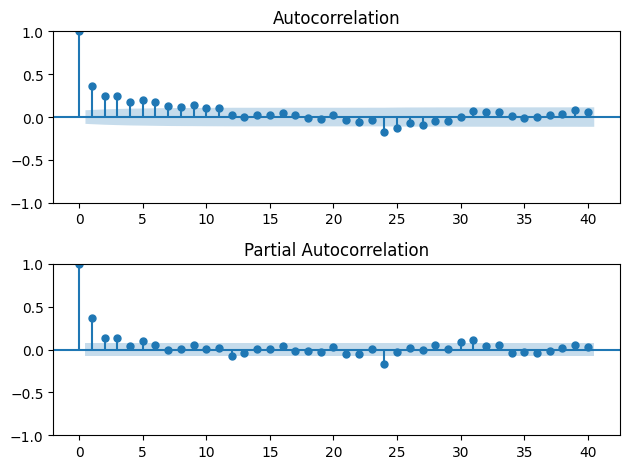

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_acf(df['diff'].dropna(), ax=ax1, lags=40)
plot_pacf(df['diff'].dropna(), ax=ax2, lags=40)
plt.tight_layout()
plt.show()

ADF Statistic (Differenced): -7.2676221480431025
p-value (Differenced): 1.6194194521249752e-10


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA RMSE: 20.9156612827297


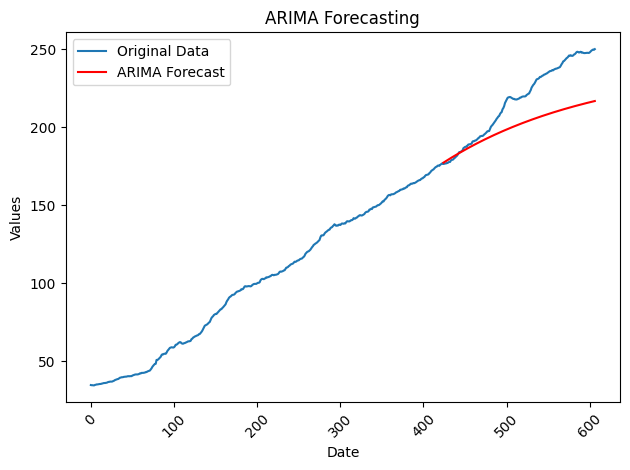

In [ ]:
# ARIMA Forecasting
# Since p-value is > 0.05, data is not stationary. We must difference.
# We will check the differenced data's ADF test.
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

differenced_data = df['CPIFABSL'].diff().dropna()
adf_diff_result = adfuller(differenced_data)
print(f'ADF Statistic (Differenced): {adf_diff_result[0]}')
print(f'p-value (Differenced): {adf_diff_result[1]}')

# If the differenced data is stationary (p<0.05), we can use d=1.

# Split data into train and test sets
train_size = int(len(df) * 0.7)
train, test = df['CPIFABSL'][:train_size], df['CPIFABSL'][train_size:]

# Fit ARIMA model.
# The parameters (p, d, q) should be chosen based on ACF and PACF plots, or auto arima.
# Here, we use the graphs
model = ARIMA(train, order=(1, 1, 2))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {rmse}')

# Plot the results

plt.plot(df.index, df['CPIFABSL'], label='Original Data')
plt.plot(test.index, forecast, color='red', label='ARIMA Forecast')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7k4bzi8h/rc2elbpx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7k4bzi8h/dkagq81c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64893', 'data', 'file=/tmp/tmp7k4bzi8h/rc2elbpx.json', 'init=/tmp/tmp7k4bzi8h/dkagq81c.json', 'output', 'file=/tmp/tmp7k4bzi8h/prophet_modelmuti363l/prophet_model-20250408054419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:44:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:44:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 12.04753603573918


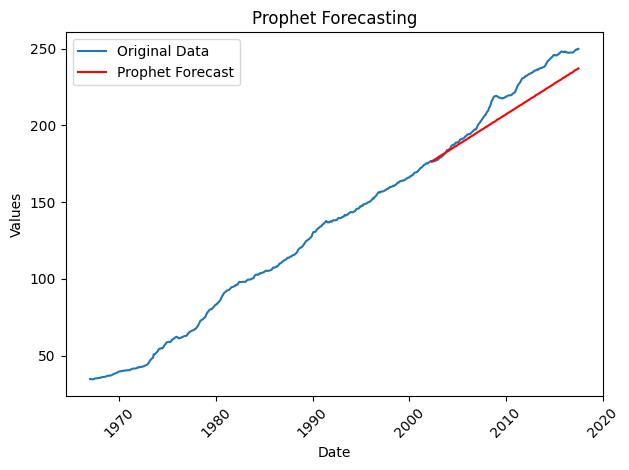

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the dataset
df = pd.read_csv('/content/FB - data.csv')

# Prepare data for Prophet
prophet_df = df[['observation_date', 'CPIFABSL']].copy()
prophet_df.rename(columns={'observation_date': 'ds', 'CPIFABSL': 'y'}, inplace=True)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Split data into train and test sets
train_size = int(len(prophet_df) * 0.7)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

# Fit Prophet model
model = Prophet()
model.fit(train_df)

# Make future dataframe for forecasting
future = model.make_future_dataframe(periods=len(test_df), freq='MS') # Monthly start frequency

# Forecast
forecast = model.predict(future)

# Extract predictions for the test period
prophet_predictions = forecast['yhat'][-len(test_df):].values
actuals = test_df['y'].values

# Calculate RMSE
rmse = sqrt(mean_squared_error(actuals, prophet_predictions))
print(f'Prophet RMSE: {rmse}')

# Plot the forecast

plt.plot(prophet_df['ds'], prophet_df['y'], label='Original Data')
plt.plot(test_df['ds'], prophet_predictions, color='red', label='Prophet Forecast')
plt.title('Prophet Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
NARNN RMSE: 3.57009151018733


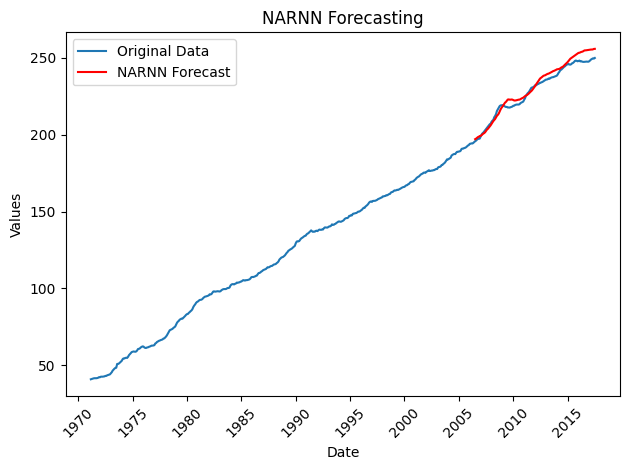

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load dataset
df = pd.read_csv('/content/FB - data.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)

# Extract values
data = df['CPIFABSL'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset for NARNN
def create_narnn_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Parameters
look_back = 50
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size

# Create the dataset
X, y = create_narnn_dataset(scaled_data, look_back)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for NARNN (no time steps dimension needed like LSTM)
n_features = 1
X_train = X_train.reshape((X_train.shape[0], look_back * n_features))
X_test = X_test.reshape((X_test.shape[0], look_back * n_features))

# Build NARNN model
narnn_model = Sequential()
narnn_model.add(Dense(50, activation='relu', input_shape=(look_back * n_features,)))
narnn_model.add(Dense(50, activation='relu'))
narnn_model.add(Dense(1))
narnn_model.compile(optimizer='adam', loss='mse')

# Train the NARNN model
narnn_model.fit(X_train, y_train, epochs=100, verbose=0, batch_size=32)

# Make predictions
scaled_predictions = narnn_model.predict(X_test)

# Inverse transform predictions
predictions = scaler.inverse_transform(scaled_predictions)
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print(f'NARNN RMSE: {rmse}')

# Plot results

plt.plot(df.index[look_back:], scaler.inverse_transform(scaled_data[look_back:]), label='Original Data')
plt.plot(df.index[train_size + look_back:], predictions, color='red', label='NARNN Forecast')
plt.title('NARNN Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#TR - dataset
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a CSV file named 'your_data.csv'
# and has columns 'date' and 'values'

df = pd.read_csv('/content/TR-data.csv')  # Replace 'your_data.csv' with your file path

df.head()

,observation_date,CPITRNSL
0,1947-01-01,17.9
1,1947-02-01,17.9
2,1947-03-01,18.1
3,1947-04-01,18.3
4,1947-05-01,18.3


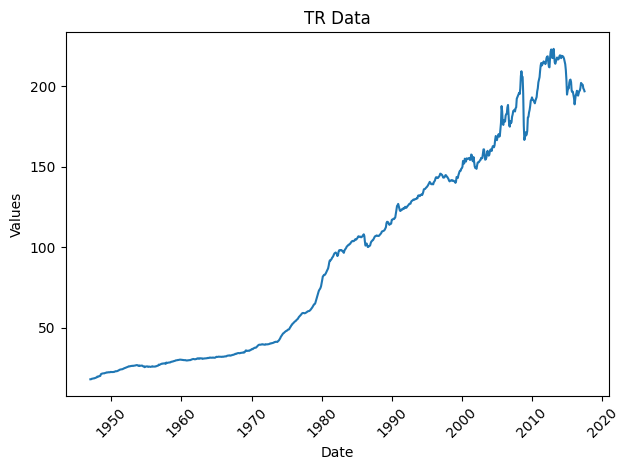

In [ ]:
#TR - dataset
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is in a CSV file named 'your_data.csv'
# and has columns 'date' and 'values'

df = pd.read_csv('/content/TR-data.csv')  # Replace 'your_data.csv' with your file path

# Convert 'date' column to datetime objects
df['observation_date'] = pd.to_datetime(df['observation_date'])

# Set the 'date' column as the index of the DataFrame
df.set_index('observation_date', inplace=True)

# Plot the 'values' column against the index (dates)
plt.plot(df.index, df['CPITRNSL'])

# Add title and labels
plt.title('TR Data')
plt.xlabel('Date')
plt.ylabel('Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust plot layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df.shape

(847, 1)

In [ ]:
adf_result = adfuller(df['CPITRNSL'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: 0.2913034289453401
p-value: 0.9769419559748707


In [ ]:
df['diff'] = df['CPITRNSL'].diff().dropna()

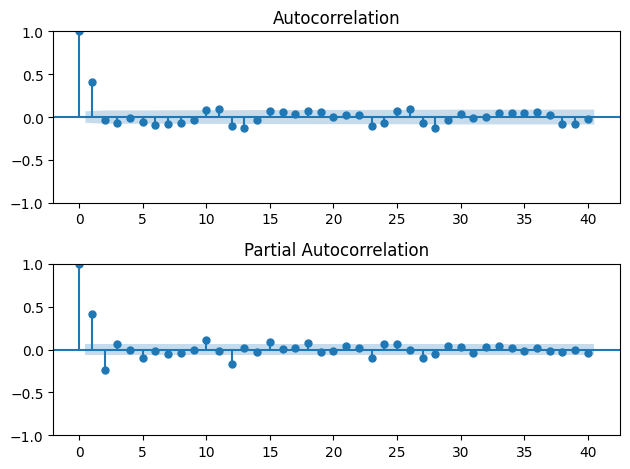

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_acf(df['diff'].dropna(), ax=ax1, lags=40)
plot_pacf(df['diff'].dropna(), ax=ax2, lags=40)
plt.tight_layout()
plt.show()

ADF Statistic (Differenced): -7.867505968541297
p-value (Differenced): 5.088085842573112e-12


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

ARIMA RMSE: 13.961463503364996


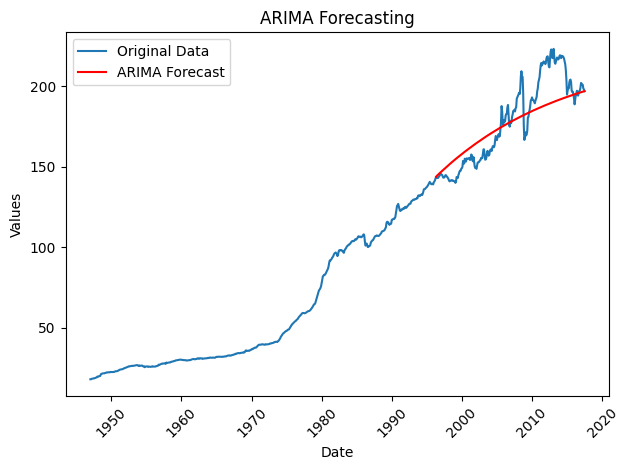

In [ ]:
# ARIMA Forecasting
# Since p-value is > 0.05, data is not stationary. We must difference.
# We will check the differenced data's ADF test.
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

differenced_data = df['CPITRNSL'].diff().dropna()
adf_diff_result = adfuller(differenced_data)
print(f'ADF Statistic (Differenced): {adf_diff_result[0]}')
print(f'p-value (Differenced): {adf_diff_result[1]}')

# If the differenced data is stationary (p<0.05), we can use d=1.

# Split data into train and test sets
train_size = int(len(df) * 0.7)
train, test = df['CPITRNSL'][:train_size], df['CPITRNSL'][train_size:]

# Fit ARIMA model.
# The parameters (p, d, q) should be chosen based on ACF and PACF plots, or auto arima.
# Here, we use the graphs
model = ARIMA(train, order=(1, 1, 3))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {rmse}')

# Plot the results

plt.plot(df.index, df['CPITRNSL'], label='Original Data')
plt.plot(test.index, forecast, color='red', label='ARIMA Forecast')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7k4bzi8h/fmg954ev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7k4bzi8h/mhme_0gz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76324', 'data', 'file=/tmp/tmp7k4bzi8h/fmg954ev.json', 'init=/tmp/tmp7k4bzi8h/mhme_0gz.json', 'output', 'file=/tmp/tmp7k4bzi8h/prophet_modelgra9qw6x/prophet_model-20250408054521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:45:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:45:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 12.693376709751742


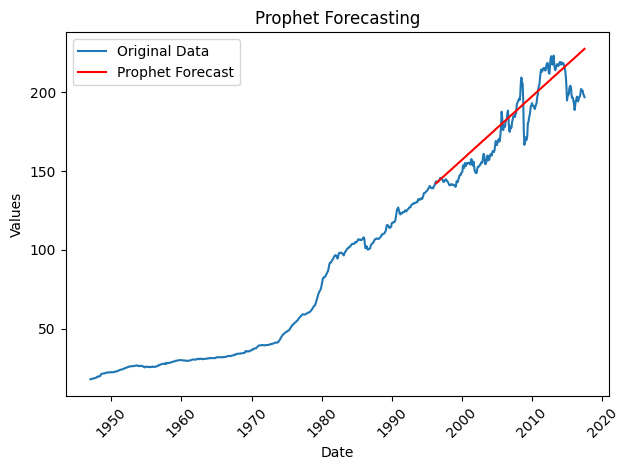

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the dataset
df = pd.read_csv('/content/TR-data.csv')

# Prepare data for Prophet
prophet_df = df[['observation_date', 'CPITRNSL']].copy()
prophet_df.rename(columns={'observation_date': 'ds', 'CPITRNSL': 'y'}, inplace=True)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Split data into train and test sets
train_size = int(len(prophet_df) * 0.7)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

# Fit Prophet model
model = Prophet()
model.fit(train_df)

# Make future dataframe for forecasting
future = model.make_future_dataframe(periods=len(test_df), freq='MS') # Monthly start frequency

# Forecast
forecast = model.predict(future)

# Extract predictions for the test period
prophet_predictions = forecast['yhat'][-len(test_df):].values
actuals = test_df['y'].values

# Calculate RMSE
rmse = sqrt(mean_squared_error(actuals, prophet_predictions))
print(f'Prophet RMSE: {rmse}')

# Plot the forecast

plt.plot(prophet_df['ds'], prophet_df['y'], label='Original Data')
plt.plot(test_df['ds'], prophet_predictions, color='red', label='Prophet Forecast')
plt.title('Prophet Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
NARNN RMSE: 7.2240587004348


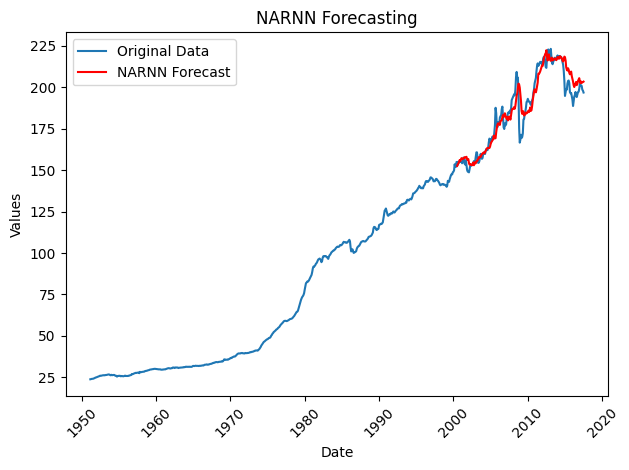

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load dataset
df = pd.read_csv('/content/TR-data.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)

# Extract values
data = df['CPITRNSL'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset for NARNN
def create_narnn_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Parameters
look_back = 50
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size

# Create the dataset
X, y = create_narnn_dataset(scaled_data, look_back)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for NARNN (no time steps dimension needed like LSTM)
n_features = 1
X_train = X_train.reshape((X_train.shape[0], look_back * n_features))
X_test = X_test.reshape((X_test.shape[0], look_back * n_features))

# Build NARNN model
narnn_model = Sequential()
narnn_model.add(Dense(50, activation='relu', input_shape=(look_back * n_features,)))
narnn_model.add(Dense(50, activation='relu'))
narnn_model.add(Dense(1))
narnn_model.compile(optimizer='adam', loss='mse')

# Train the NARNN model
narnn_model.fit(X_train, y_train, epochs=100, verbose=0, batch_size=32)

# Make predictions
scaled_predictions = narnn_model.predict(X_test)

# Inverse transform predictions
predictions = scaler.inverse_transform(scaled_predictions)
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print(f'NARNN RMSE: {rmse}')

# Plot results

plt.plot(df.index[look_back:], scaler.inverse_transform(scaled_data[look_back:]), label='Original Data')
plt.plot(df.index[train_size + look_back:], predictions, color='red', label='NARNN Forecast')
plt.title('NARNN Forecasting')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()